In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct  4 17:57:07 2025

@author: coletamburri
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib as mpl
import tol_colors
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.io import readsav
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy
import pandas as pd


def normalize(arr):
    norm_arr = []
    minimum = np.nanmin(arr)
    maximum = np.nanmax(arr)
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr

def normalize_range(arr,lowlim=0,highlim=-1,contmin = 0):
    if contmin > 0:
        minimum = arr[contmin]
    else:
        minimum = np.nanmin(arr[lowlim:highlim])
    maximum = np.nanmax(arr[lowlim:highlim])
    diff_arr = maximum - minimum   
    return (arr-minimum)/diff_arr 

c=2.99e5
lamb2 = 486.1
mu1 = 0.4760111410077789
mu2 = 0.4266927415494022
mu3=.54
muhead = 1

#ViSP instrument
fwhm = .003 # in nm # 0.003 is from the convolution and comparison to atlas, 
            #but 0.01 makes RADYN/DKIST match a lot better? extra gaussian impact somewhere?
            # 0.001 to preserve shape of Hbeta in care for deep heating...
flagh20 = 1
flagh20sum = 0

#only one of the following should be 1
flagb = 0
flagvt = 0
flagt = 0

hbetawl=486.135
lamb0=486.135
hbeta_low = 422
hbeta_high = 706



lowvisp=148
highvisp=148+91
#lowvisp=0
#highvisp=-1

def veltrans(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian(x, c1, mu1, sigma1):
    res = c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

def gaussfit(params,selwl,sel):
    fit = gaussian( selwl, params )
    return (fit - sel)

def double_gaussian( x, c1, mu1, sigma1, c2, mu2, sigma2 ):
    res =   (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )) \
          + (c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    return res

def tocgs(self, w, s):
    clight=2.99792458e10         #speed of light [cm/s]
    joule_2_erg=1e7
    aa_to_cm=1e-8
    s *=joule_2_erg/aa_to_cm # from Watt /(cm2 ster AA) to erg/(s cm2 ster cm)
    s *=(w*aa_to_cm)**2/clight   # to erg/
    return s

def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

#example convolution with gaussian psf
def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr

#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range):
   
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    #dw=new_dispersion_range[1]-new_dispersion_range[0]
    #dw=dw
    #tw=(np.arange(ntw)-ntw//2)*dw
    
    stddev_pixels = fwhm/(new_dispersion_range[1]-new_dispersion_range[0])
    gaussian_kernel = Gaussian1DKernel(stddev=stddev_pixels)
   	
    #psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    #yconv = convolve(yatlas, psf, mode='same', method='fft')
    yconv = convolve(yatlas,gaussian_kernel)
    
    return yconv

def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.nm)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [247]:
feature = 'symmetric' #red or deepheating or symmetric or blueshift


In [234]:
#read-in from alternative calibration:
dkist_file_newcalib = '/Users/coletamburri/Desktop/11Aug2024_Cclass_Hbeta_calib_bestseeing.npz'
dkist_file = np.load(dkist_file_newcalib)
dkist_scale = dkist_file['scaled']
dkist_int = dkist_file['flare']
dkist_wl = dkist_file['wl']

dkist_avg = np.mean(dkist_int[lowvisp:highvisp,hbeta_low:hbeta_high,:],1)
dkist_blue = dkist_int[lowvisp:highvisp,hbeta_low+20,:]

In [235]:
# dkist_file_qs = '/Users/coletamburri/Desktop/qs_calib_sample.npz'
# qs_samp = np.load(dkist_file_qs)
# qs_wl = qs_samp['dispersion_range_fin']
# qs_int = qs_samp['calibrated_qs']
# wlsel_fts = qs_samp['wlsel_fts']
# ilamsel_fts = qs_samp['ilamsel_fts']

In [250]:
dkist_coord_file = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSPcoords.npz'
dkist_coords = np.load(dkist_coord_file)

xarr_caII = dkist_coords['xarr_caII']
yarr_caII = dkist_coords['yarr_caII']

xarr_hbeta = dkist_coords['xarr_hbeta']
yarr_hbeta = dkist_coords['yarr_hbeta']

In [251]:
indices_file =  np.load('/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/Hbeta_inds_'+feature+'.npz')
x_hbeta_inds = indices_file['x_other_inds']
y_hbeta_inds = indices_file['y_other_inds']
x_coords_arcsec = indices_file['x_coords_arcsec']
y_coords_arcsec = indices_file['y_coords_arcsec']

In [252]:
#define models to compare
base = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/'
modelnameqs1 = '11Aug_Cclass_A_final_0s_mu1.npz' #same for all
modelnameqs05 = '11Aug_Cclass_A_final_0s_mu0.5.npz' #same for all
#modelnameqs05 = '11Aug_Cclass_A_final_0s_mu0.5.npz' #same for all
modelnameqs0 = 'rhf1d_11Aug_Cclass_A_final_0s_mu0.npz' #same for all



models = []
# for redshift figure
if feature == 'red':
    models.append('11Aug_Cclass_D_final_22s_mu1.npz') #region D, 22s (time-consistent; small redshift)
    models.append('11Aug_Cclass_A_final_7s_mu1.npz') #region AB, 7s (big redshift)
    models.append('rhf1d_11Aug_Cclass_TC_8s_mu1.npz') # region D, TC, 8s (some redshift)
    models.append('rhf1d_11Aug_Cclass_EB+TC_8s_mu1.npz') # region D, EB+TC, 8s (more redshift than TC
elif feature == 'deepheating':
    models.append('11Aug_Cclass_deepheating_12s_mu1.npz') #deepheating, 12s 
    models.append('11Aug_Cclass_deepheating_12s_mu0.5.npz')# also deepheating at 12s with mu close to 0.5?
    models.append('rhf1d_11Aug_Cclass_deepheating_12s_mu0.npz')# also deepheating at 12s with mu close to 0?
elif feature == 'symmetric':
    models.append('11Aug_Cclass_A_final_36s_5vt_mu1.npz') #time-consistent model for region AB
    models.append('11Aug_Cclass_A_final_36s_7vt_mu0.5.npz')#same but at mu=0.5
    models.append('11Aug_Cclass_A_final_36s_5vt_mu0.5.npz')#same but at mu=0.5

    #extra models - to explain small redshifts?
    models.append('11Aug_Cclass_A_final_7s_mu1.npz') #region AB, 7s (big redshift)
    models.append('rhf1d_11Aug_Cclass_EB+TC_8s_mu1.npz') # region D, EB+TC, 8s (more redshift than TC
    #models.append('11Aug_Cclass_A_final_36s_nonuniform_mu0.5.npz') #first attempt at nonuniform vt, mu=0.5
elif feature == 'blueshift':
    models.append('rhf1d_11Aug_Cclass_D_proton_35s_mu1.npz') # proton beam at 35 post-RH
    models.append('11Aug_Cclass_regionD_proton_21s_mu1.npz') # proton beam at 21 post-RH
    models.append('rhf1d_11Aug_Cclass_gentleevap_13s_mu1.npz') # gentle evaporation at 13 s post-RH
    RADYNonly_proton = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_Cclass_d_proton_v2.sav'
    RADYNonly_ge = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_gentleevaptake2.sav'

cc = []
for i in range(len(x_hbeta_inds)):
    cc.append([x_hbeta_inds[i],y_hbeta_inds[i]])


In [253]:
dkist_blue = dkist_int[lowvisp:highvisp,530,:]


[]

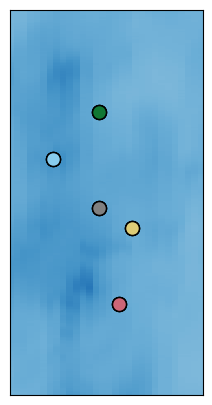

In [254]:
colors=tol_colors.tol_cset('muted')

if feature=='symmetric':
    choice_is = [2,7,8,10,11]
elif feature=='blueshift':
    choice_is = [3,6,9,11]
elif feature=='red':
    choice_is = [3,5,6,7]
elif feature=='deepheating':
    choice_is = [0,1,2,3,4,5]
    

dkist_blue = dkist_int[lowvisp:highvisp,hbeta_low-20,:]
dkist_center = dkist_int[lowvisp:highvisp,int(round(hbeta_high+hbeta_low)/2),:]

fig,ax=plt.subplots(figsize=(5,5));

if feature=='blueshift':
    ax.pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(dkist_blue[:,:-1]),cmap='Blues')
else:
    ax.pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(dkist_avg[:,:-1]),cmap='Blues')

for i in range(len(choice_is)):
    for i in range(len(choice_is)):
        if i==1:
            ax.scatter(x_coords_arcsec[int(choice_is[i])],y_coords_arcsec[int(choice_is[i])],100,marker='o',c='gray',edgecolor='black')
        else:
            ax.scatter(x_coords_arcsec[int(choice_is[i])],y_coords_arcsec[int(choice_is[i])],100,marker='o',c=colors[i],edgecolor='black')
        


if feature =='blueshift':
    ax.set_ylim([-233,-222])
    ax.set_xlim([759,765])
elif feature=='symmetric':
    ax.set_ylim([-241,-235])
    ax.set_xlim([759,762])
elif feature=='red':
    ax.set_ylim([-247,-243])
    ax.set_xlim([760,764])
elif feature=='deepheating':
    ax.set_ylim([-247,-243])
    ax.set_xlim([759,763])

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

In [255]:
model_choiceqs = np.load(base+modelnameqs05)
hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))

#define quiet sun stuff
model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
model_choiceqs_wlshift = model_choiceqs_wl-lamb0

dkist_wl_shift = dkist_wl-lamb0

yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)

In [256]:
modelscomp = []
for i in range(len(models)):
    selected = models[i]
    model_choice1 = np.load(base+selected)
    hbeta_indsh20 = np.where((model_choice1['wl_rh']>485.95) & (model_choice1['wl_rh']< 486.5))

    model_choice1_wl = model_choice1['wl_rh'][hbeta_indsh20]
    model_choice1_int = model_choice1['int_rh'][hbeta_indsh20]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
    
    yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

    if feature=='deepheating' and i==1:
        model_choiceqs = np.load(base+modelnameqs0)
        hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))
        
        #define quiet sun stuff
        model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
        model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
        model_choiceqs_wlshift = model_choiceqs_wl-lamb0
        
        dkist_wl_shift = dkist_wl-lamb0
        
        yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
    
    if feature=='symmetric':
        if i == 0 or i == 3 or i==4:
            model_choiceqs = np.load(base+modelnameqs1)
            hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))
            
            #define quiet sun stuff
            model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
            model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
            model_choiceqs_wlshift = model_choiceqs_wl-lamb0
            
            dkist_wl_shift = dkist_wl-lamb0
            
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)

    if feature=='blueshift':
        model_choiceqs = np.load(base+modelnameqs1)
        hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))
        
        #define quiet sun stuff
        model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
        model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
        model_choiceqs_wlshift = model_choiceqs_wl-lamb0
        
        dkist_wl_shift = dkist_wl-lamb0
        
        yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
        
    if feature=='red':
        model_choiceqs = np.load(base+modelnameqs1)
        hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))
        
        #define quiet sun stuff
        model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
        model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
        model_choiceqs_wlshift = model_choiceqs_wl-lamb0
        
        dkist_wl_shift = dkist_wl-lamb0
        
        yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)   
        
    model_subtract1 = yconv1-yconvqs

    modelscomp.append(model_subtract1)

# for blueshift; load RADYN-only spectra
if feature=='blueshift':
    RADYN_pb = readsav(RADYNonly_proton)
    RADYN_ge = readsav(RADYNonly_ge)

    # for proton beam run
    q_pb = RADYN_pb['q']
    nq_pb = RADYN_pb['nq']
    qnorm_pb= RADYN_pb['qnorm']
    outintt_pb = RADYN_pb['outintt']
    nmu_pb = 5

    # for ge beam run
    q_ge = RADYN_ge['q']
    nq_ge = RADYN_ge['nq']
    qnorm_ge= RADYN_ge['qnorm']
    outintt_ge = RADYN_ge['outintt']
    nmu_ge = 5

    headon_hbeta_pb = outintt_pb[70,16,4,1:nq_pb[16]]-outintt_pb[0,16,4,1:nq_pb[16]]
    headon_hbeta_pb2 = outintt_pb[52,16,4,1:nq_pb[16]]-outintt_pb[0,16,4,1:nq_pb[16]]

    headon_hbeta_ge = outintt_ge[26,16,4,1:nq_ge[16]]-outintt_ge[0,16,4,1:nq_ge[16]]

    kr=16
    
    wavelengths = (doppler_shift_to_wavelength(486.135,q_pb[kr,:-1]*qnorm_pb))[0:100].value+486.135

    hbeta_inds_RADYN = np.where((wavelengths>485.95) & (wavelengths< 486.5))

    # psf adjust, for PB
    model_choice1_wl = wavelengths[hbeta_inds_RADYN]
    model_choice1_int = headon_hbeta_pb[hbeta_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)

    modelscomp.append(yconv1)

    # psf adjust, for PB2
    model_choice1_wl = wavelengths[hbeta_inds_RADYN]
    model_choice1_int = headon_hbeta_pb2[hbeta_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)

    modelscomp.append(yconv1)
    
    # psf adjust, for GE
    model_choice1_wl = wavelengths[hbeta_inds_RADYN]
    model_choice1_int = headon_hbeta_ge[hbeta_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)
    
    modelscomp.append(yconv1)

    
    

Text(0.5, 0, 'Wavelength [nm]')

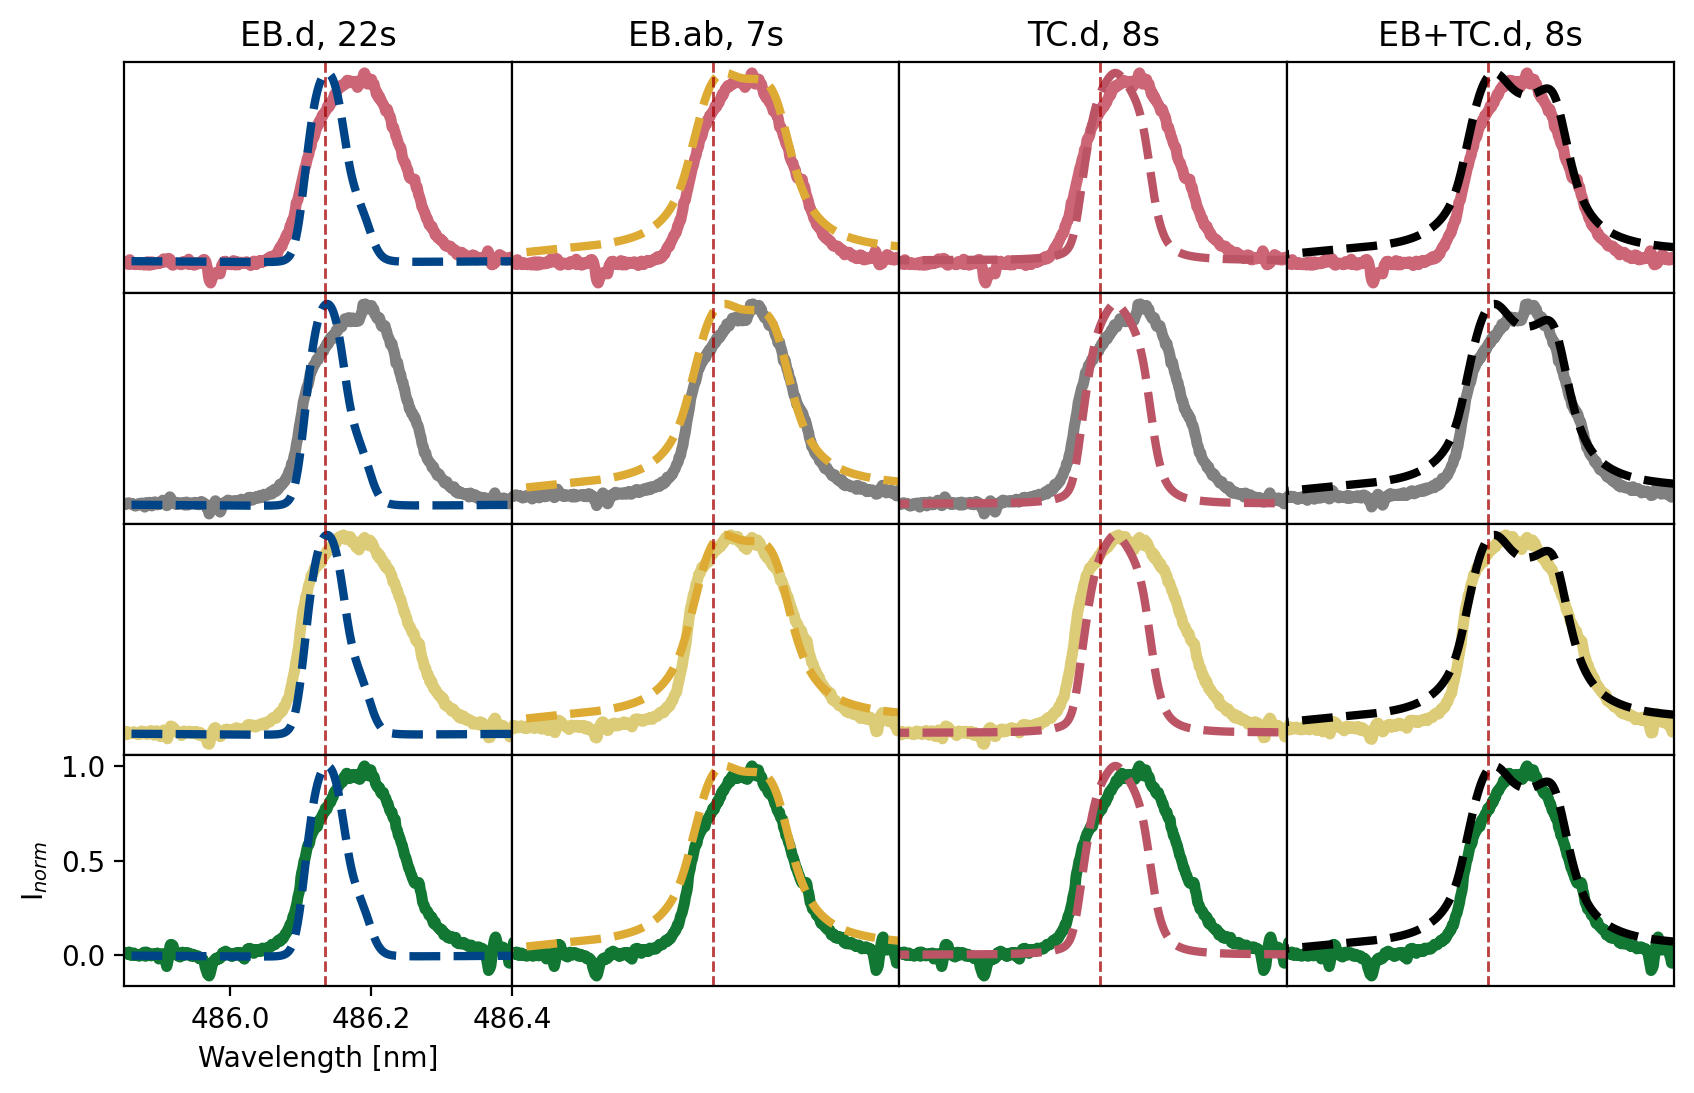

In [243]:
#for redshifts

npoints = 9
choice_is = [3,5,6,7]

#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')[0:9]

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--']
fig,ax=plt.subplots(4,4,dpi=200,figsize=(10,6))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        if feature == 'red' and i==1:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low-200),alpha=1,linewidth=4,c='gray')
        else:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low-200),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j],contmin=hbeta_low-200),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([485.85,486.4])

        if j!=0 or i!=3:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(486.135,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

        ax[i,j].axvline(486.135,c='red',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('EB.d, 22s')
ax[0,1].set_title('EB.ab, 7s') 
ax[0,2].set_title('TC.d, 8s')
ax[0,3].set_title('EB+TC.d, 8s')

fig.subplots_adjust(hspace=0, wspace=0)

ax[3,0].set_ylabel(r'I$_{norm}$')
ax[3,0].set_xlabel('Wavelength [nm]')

Text(0.5, 0, 'Wavelength [nm]')

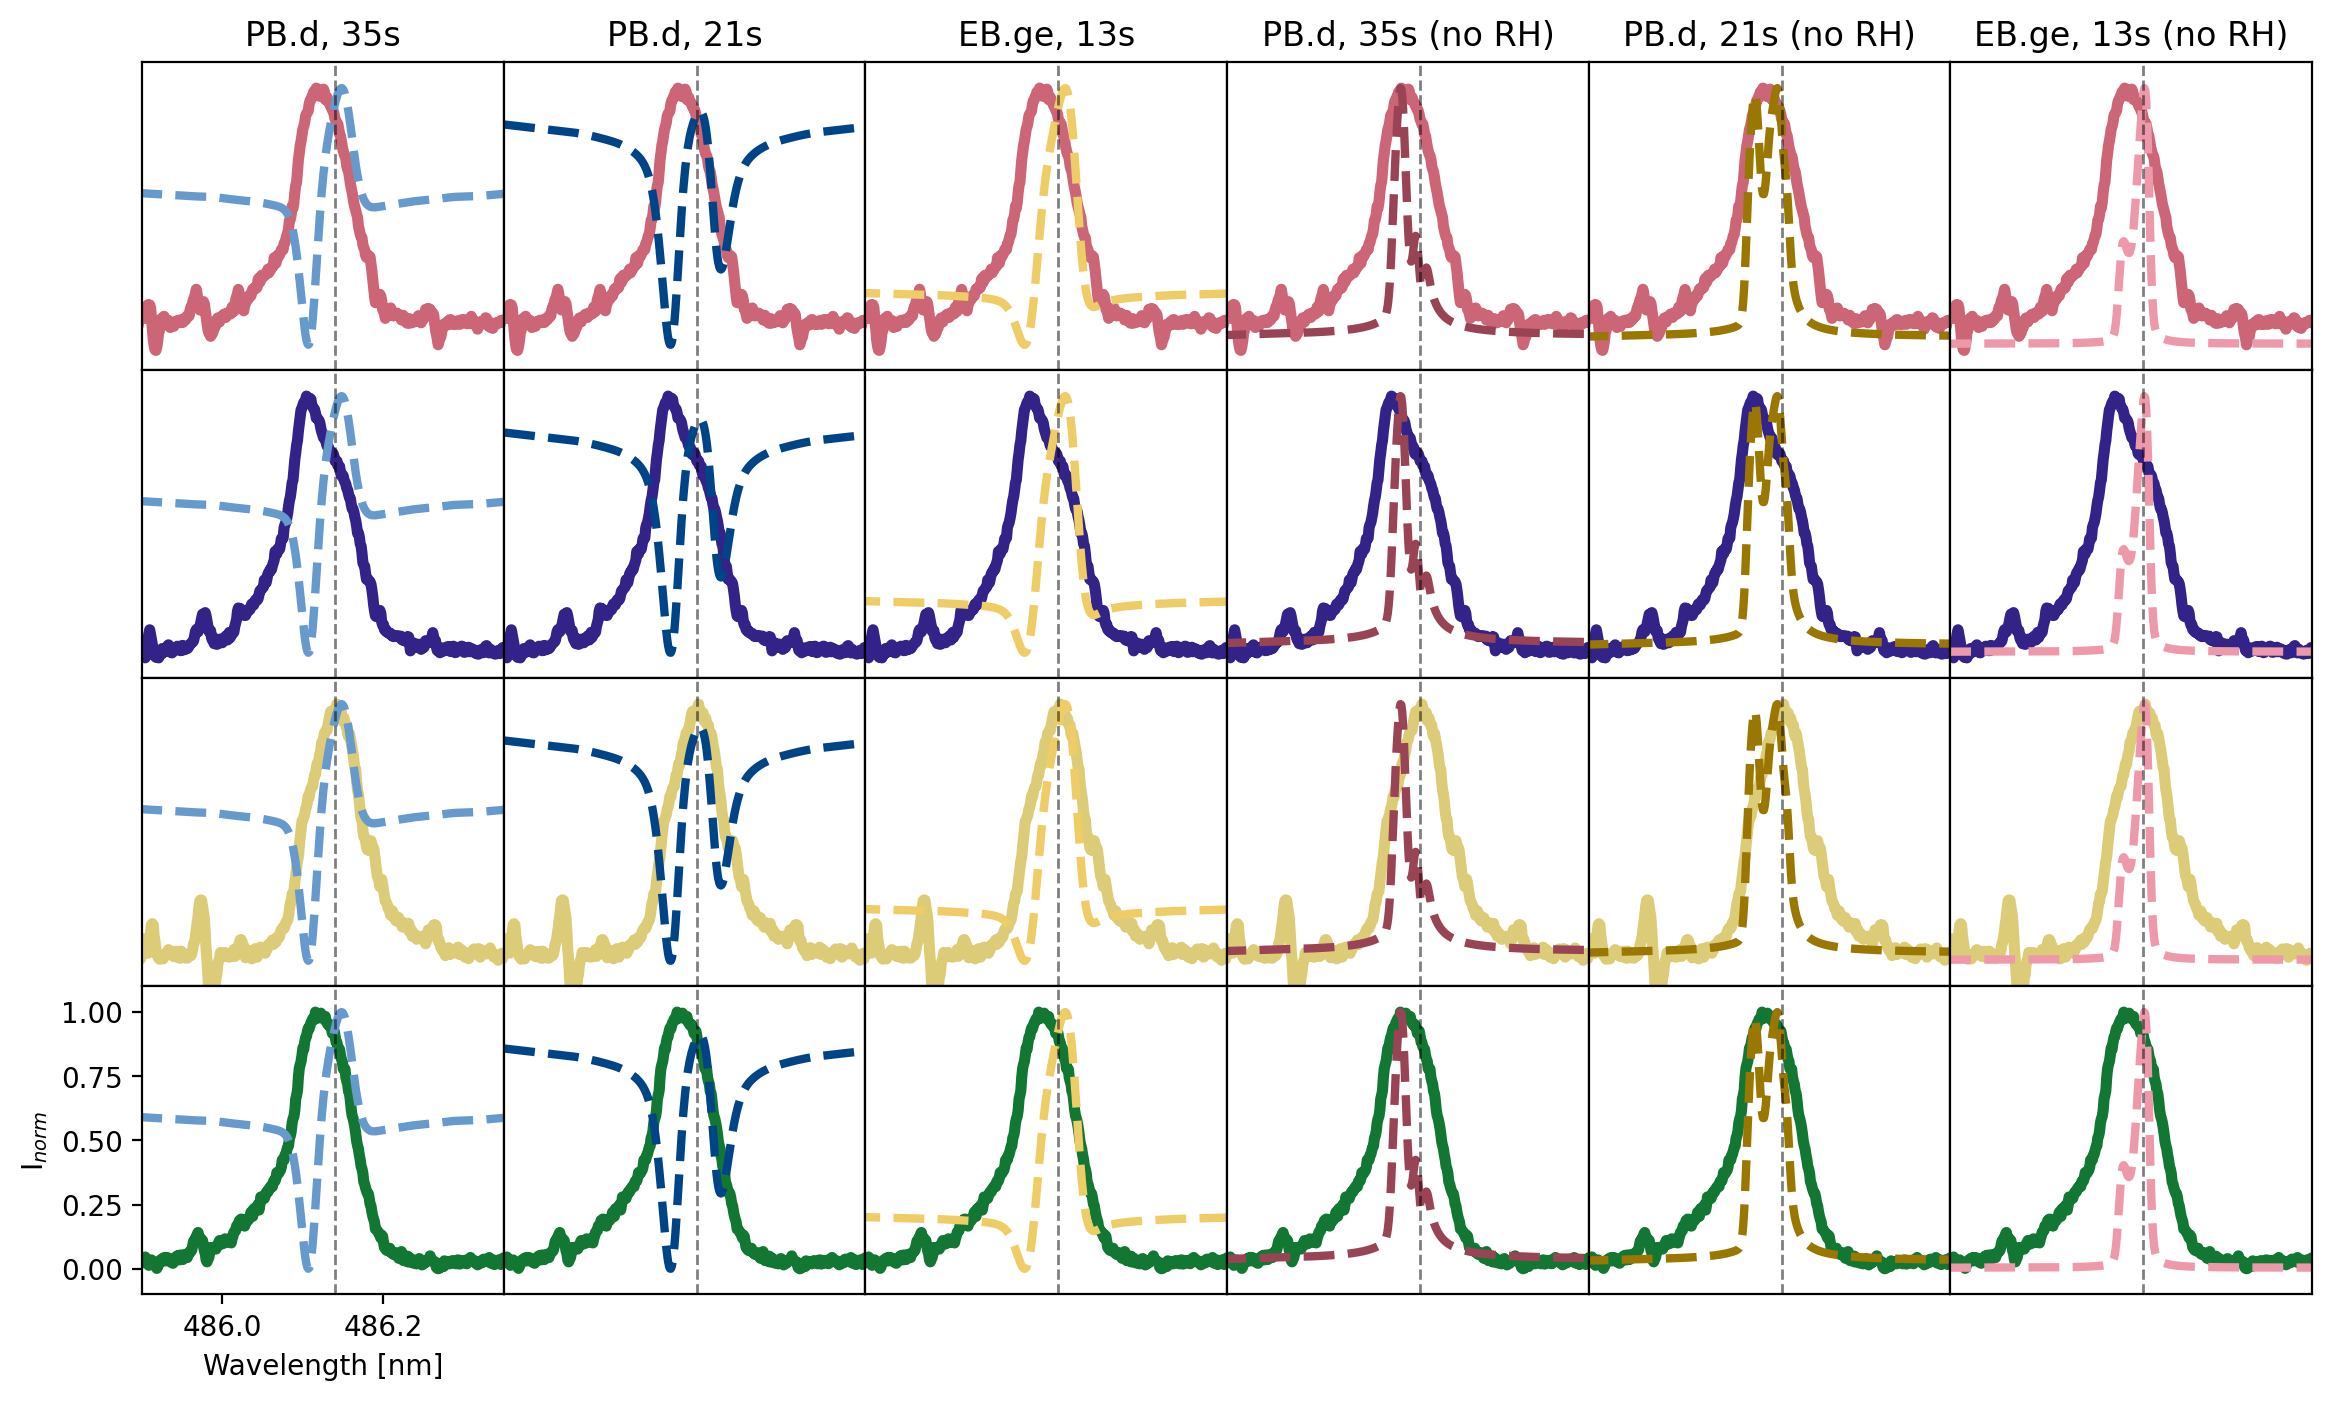

In [259]:
#for blueshifts

npoints = 9


#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('medium-contrast')

modstyles = ['--','--','--','--','--','--']
fig,ax=plt.subplots(4,6,dpi=200,figsize=(14,8))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low+20,highlim=hbeta_high),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([485.9,486.35])
        ax[i,j].set_ylim([-0.1,1.1])
        if i!=3 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(486.14,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('PB.d, 35s')
ax[0,1].set_title('PB.d, 21s')
ax[0,2].set_title('EB.ge, 13s')
ax[0,3].set_title('PB.d, 35s (no RH)')
ax[0,4].set_title('PB.d, 21s (no RH)')
ax[0,5].set_title('EB.ge, 13s (no RH)')

fig.subplots_adjust(hspace=0, wspace=0)

ax[3,0].set_ylabel(r'I$_{norm}$')
ax[3,0].set_xlabel('Wavelength [nm]')

Text(0.5, 0, 'Wavelength [nm]')

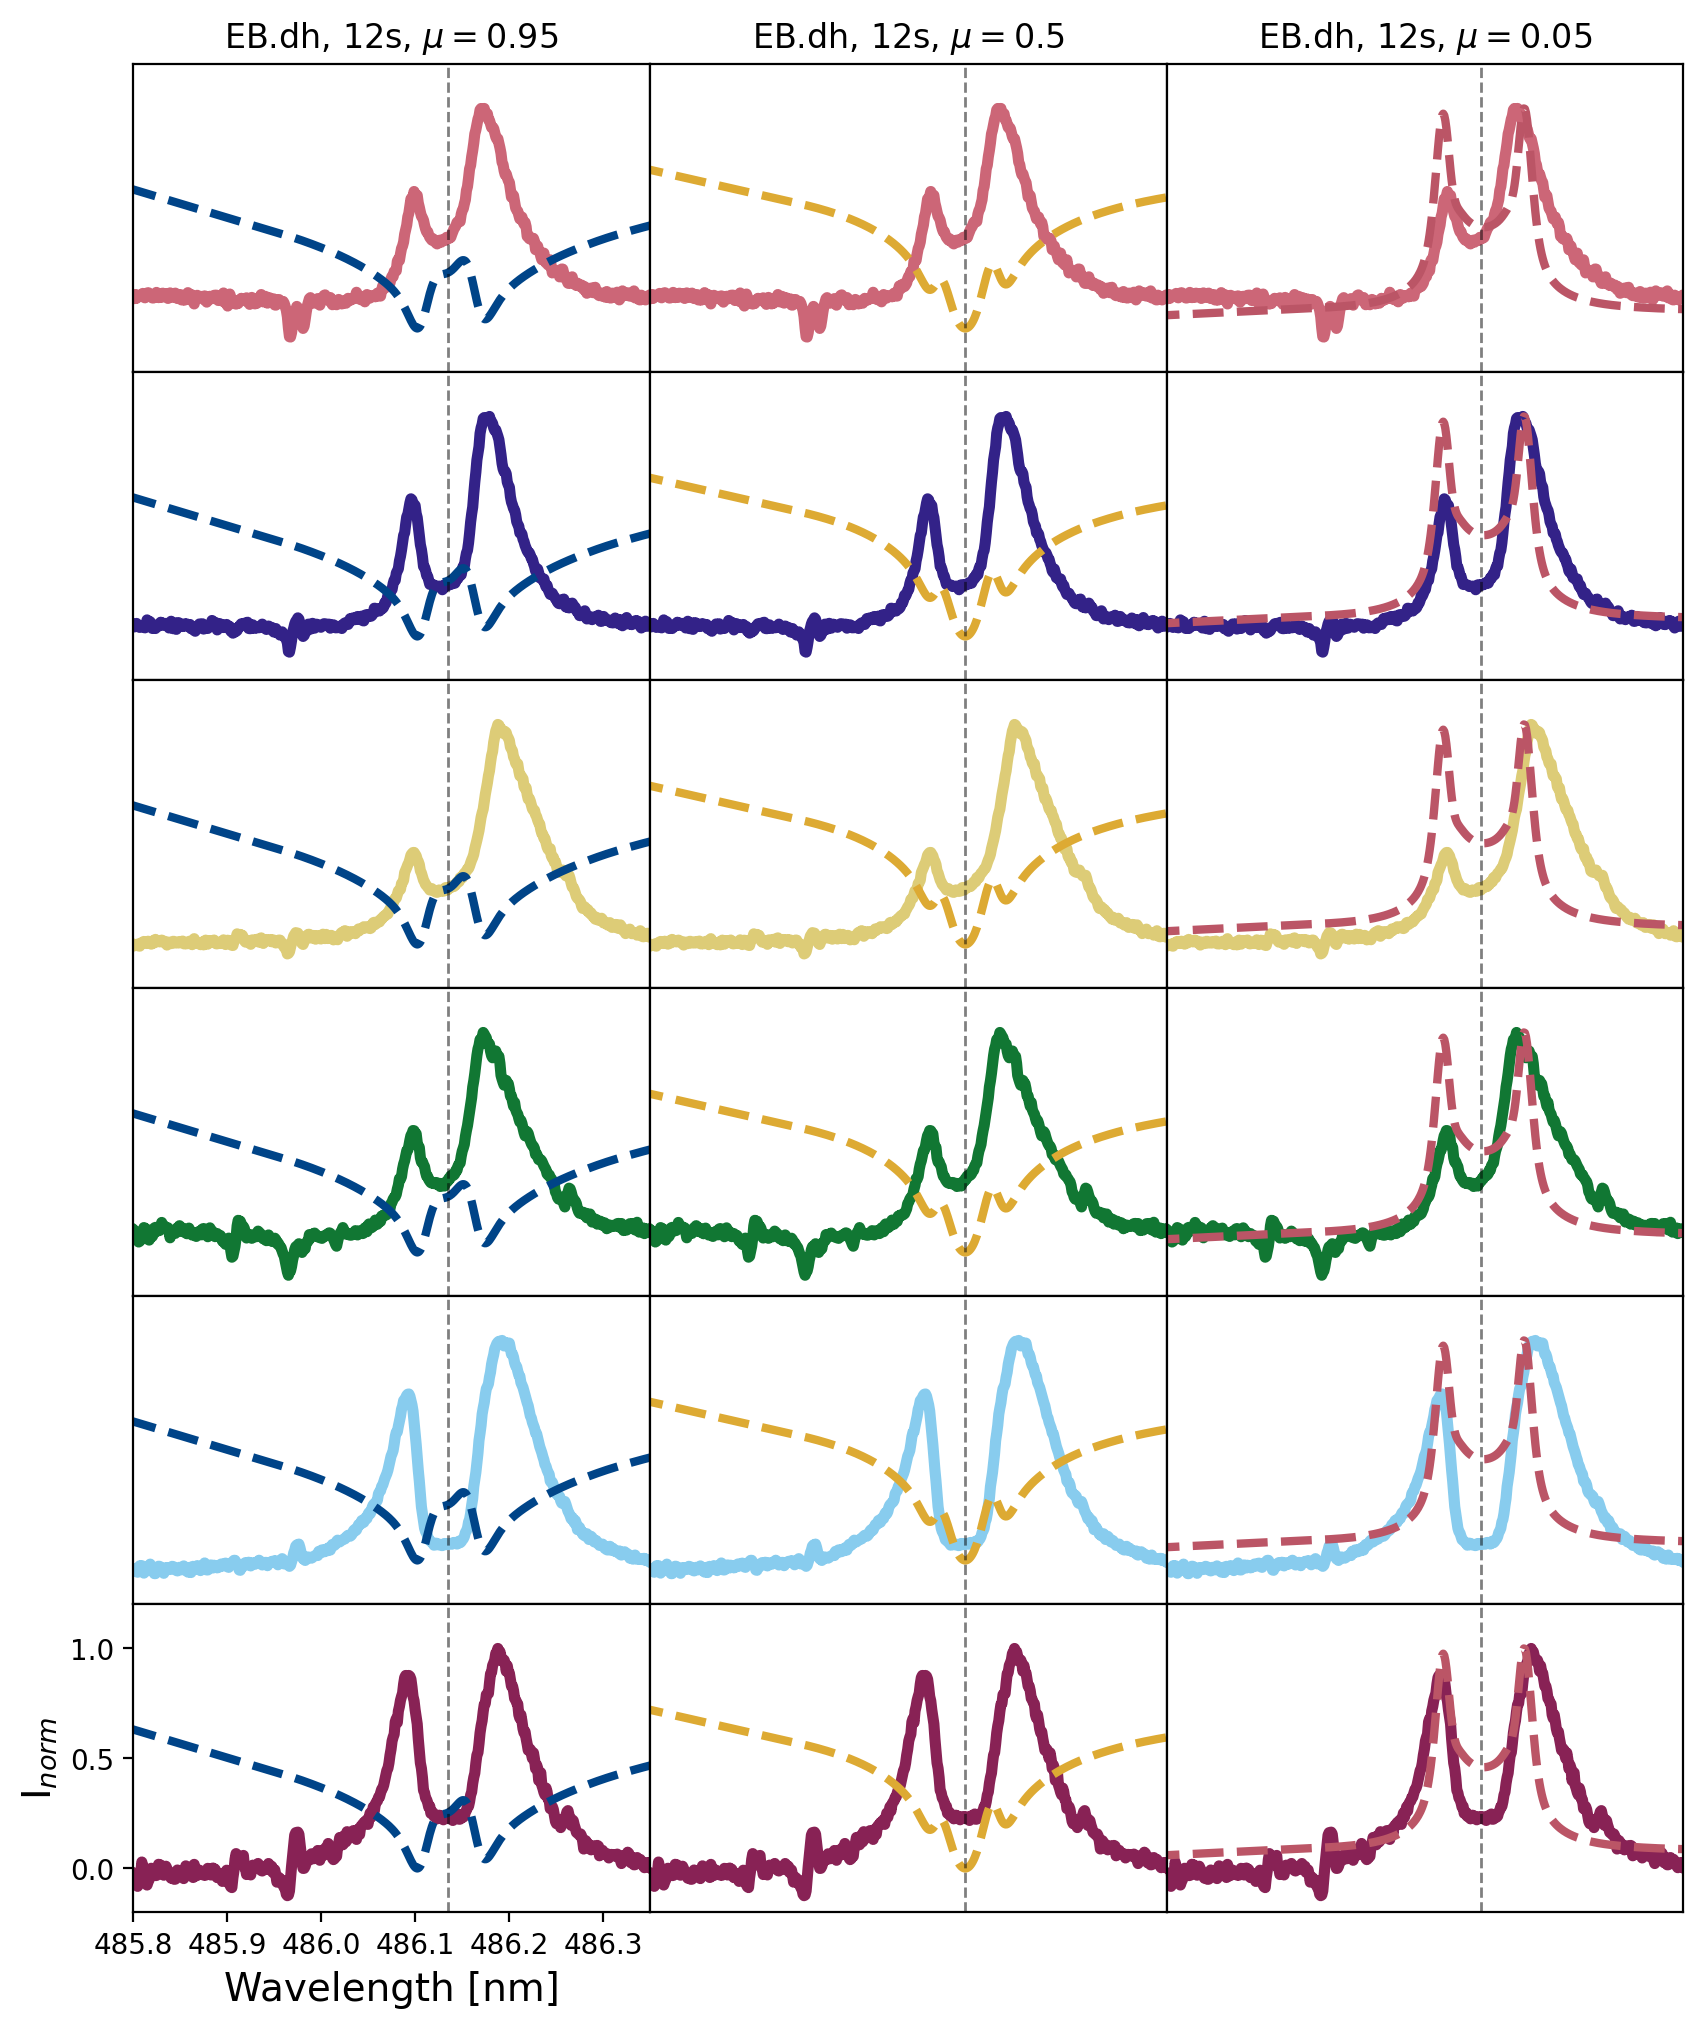

In [212]:
#for deepheating

npoints = 6


#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--']
fig,ax=plt.subplots(6,3,dpi=200,figsize=(10,12))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low,highlim=hbeta_high),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([485.8,486.35])
        ax[i,j].set_ylim([-0.2,1.2])

        if i!=5 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(486.135,c='black',linestyle='dashed',linewidth=1,alpha=0.5)


ax[0,0].set_title('EB.dh, 12s, $\mu=0.95$')
ax[0,1].set_title('EB.dh, 12s, $\mu=0.5$')
ax[0,2].set_title('EB.dh, 12s, $\mu=0.05$')


fig.subplots_adjust(hspace=0, wspace=0)

ax[5,0].set_ylabel(r'I$_{norm}$',fontsize=14)
ax[5,0].set_xlabel('Wavelength [nm]',fontsize=14)

#ax[2,0].set_xticks([396.8,396.9,397.0])
#ax[2,0].set_yticks([0,0.5,1])

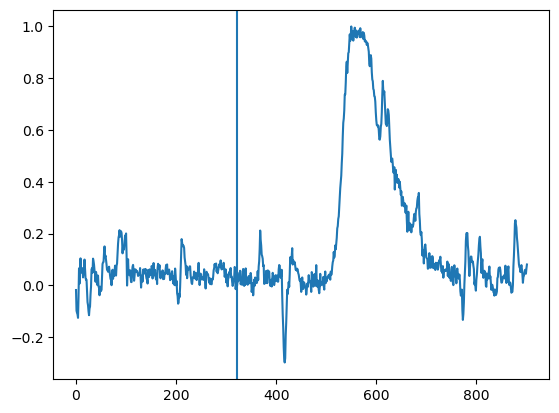

In [56]:
fig,ax=plt.subplots();
ax.plot(normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low-100,highlim=hbeta_high))
ax.axvline(hbeta_low-100)


Text(0.5, 0, 'Wavelength [nm]')

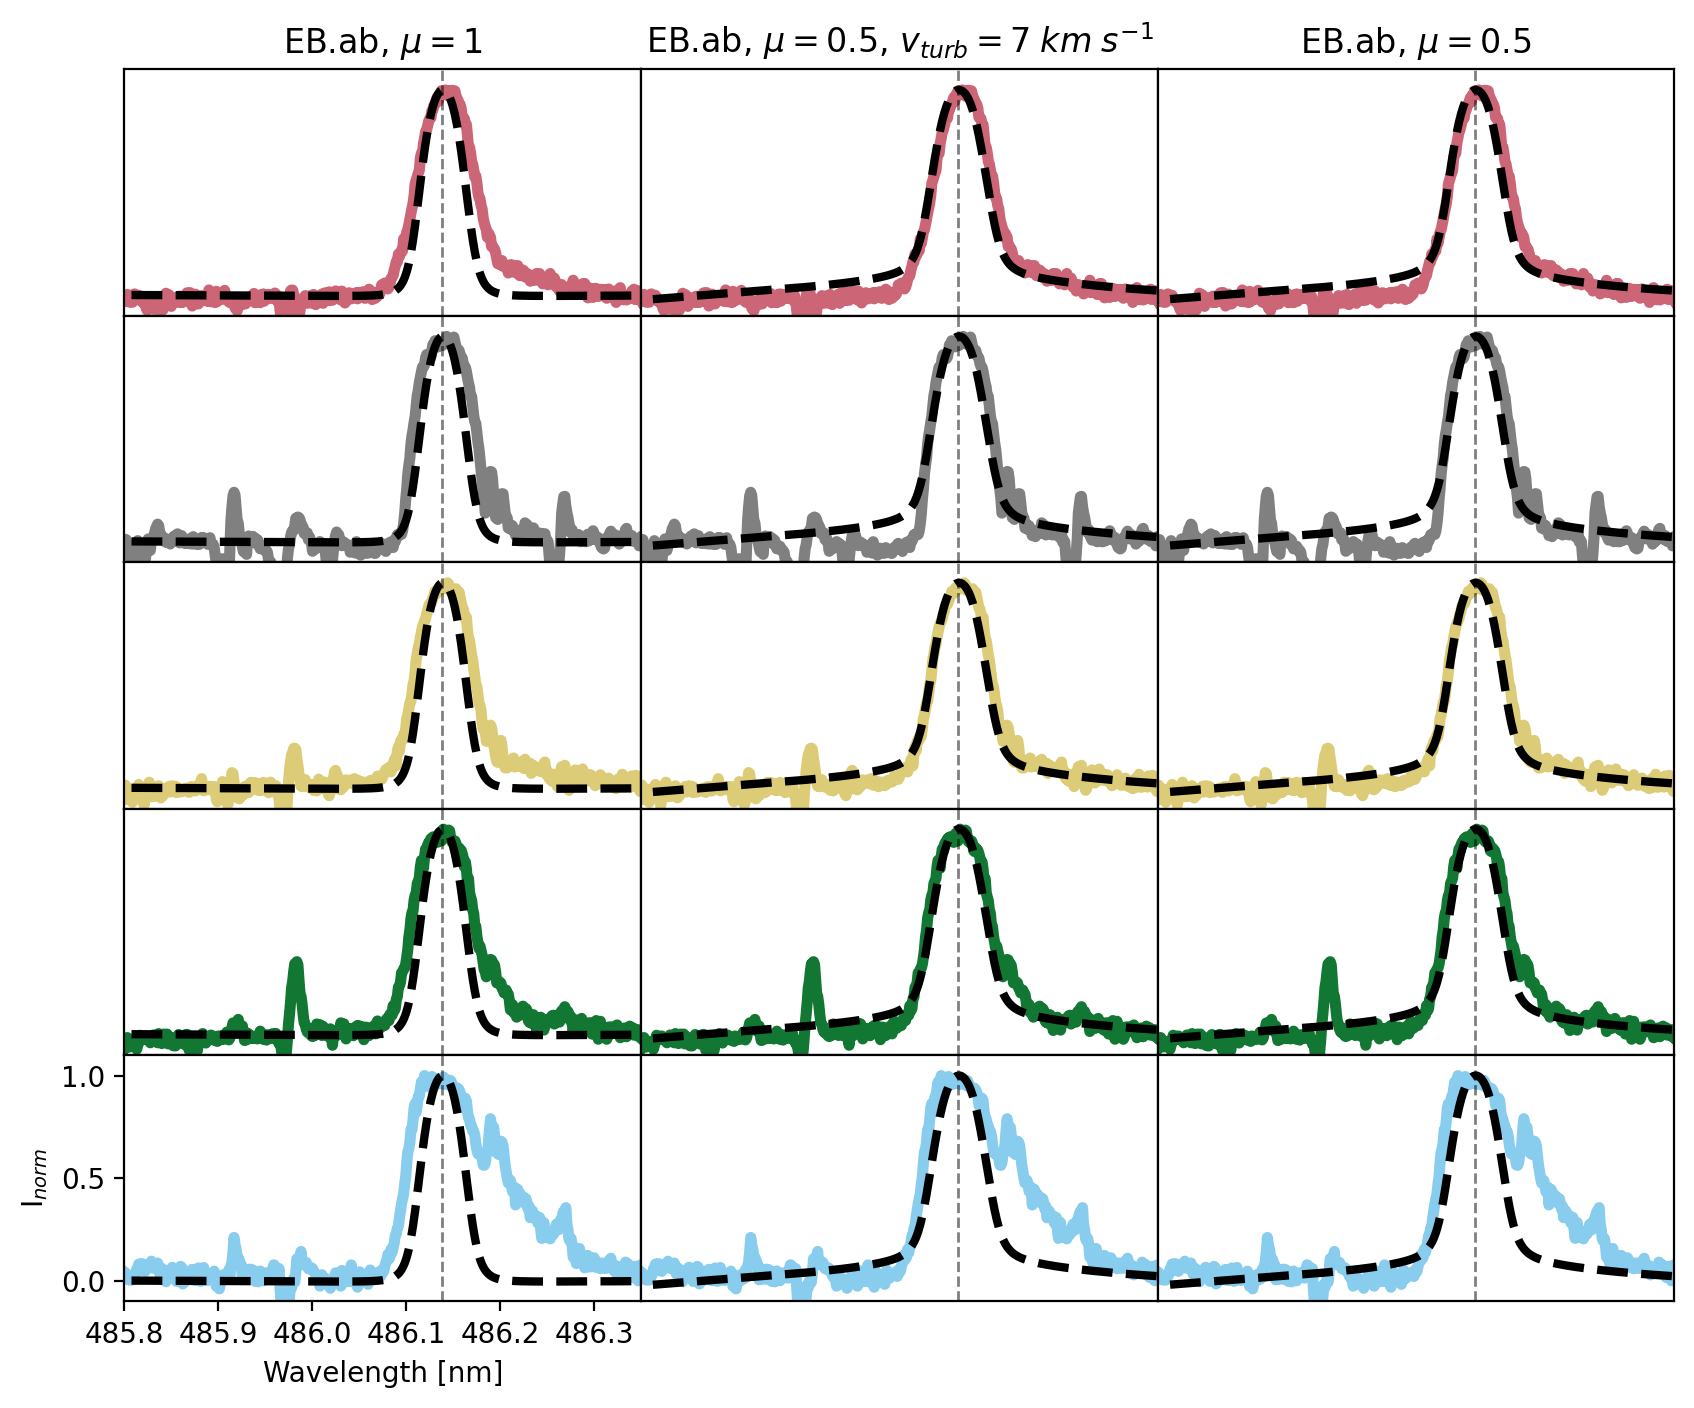

In [257]:
#for symmmetric


#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--']
fig,ax=plt.subplots(5,3,dpi=200,figsize=(10,8))
for i in range(len(choice_is)):
    for j in range(3):
        if i==1:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low-100,highlim=hbeta_high),alpha=1,linewidth=4,c='gray')
        else:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low-100,highlim=hbeta_high),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j],contmin=hbeta_low-100,highlim=hbeta_high),linewidth=3,color='black',linestyle=modstyles[j])
        ax[i,j].set_xlim([485.8,486.35])
        ax[i,j].set_ylim([-0.1,1.1])
        if i!=4 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        ax[i,j].axvline(486.1375,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

# all 36s, default is 5 km/s
ax[0,0].set_title('EB.ab, $\mu=1$')
ax[0,1].set_title('EB.ab, $\mu=0.5$, $v_{turb} = 7\;km\;s^{-1}$')
ax[0,2].set_title('EB.ab, $\mu=0.5$')


fig.subplots_adjust(hspace=0, wspace=0)

ax[4,0].set_ylabel(r'I$_{norm}$')
ax[4,0].set_xlabel('Wavelength [nm]')

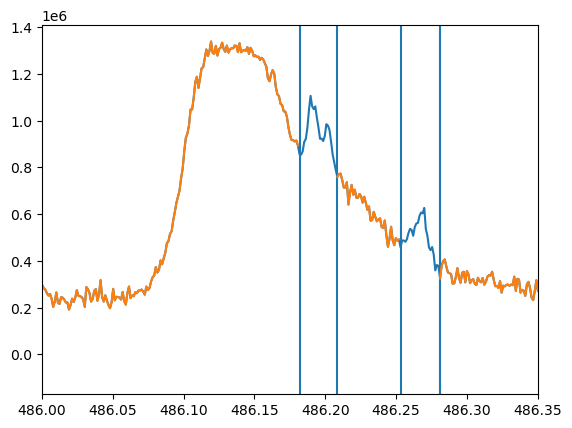

In [258]:
fig,ax=plt.subplots()
vispcurve = dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])]
ax.plot(dkist_wl,vispcurve)
ax.set_xlim([486.0,486.35])

ax.axvline(dkist_wl[606])
ax.axvline(dkist_wl[630])

ax.axvline(dkist_wl[670])
ax.axvline(dkist_wl[695])

remarr = np.arange(606,630)
remarr2 = np.arange(670,695)

vispcurve2 = vispcurve.copy()
vispcurve2[remarr]=np.nan
vispcurve2[remarr2]=np.nan


ax.plot(dkist_wl,vispcurve2)



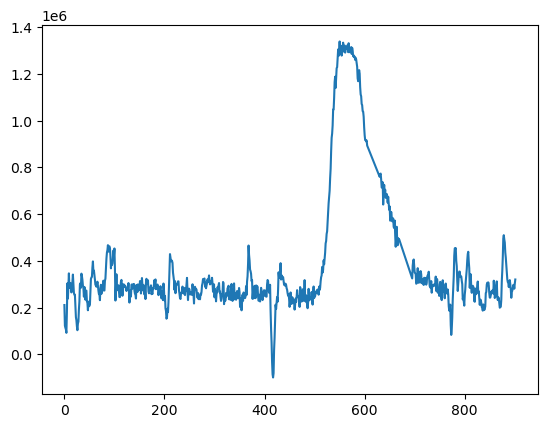

In [259]:
from scipy.interpolate import interp1d

def fill_nans_extrapolate(arr):
    """
    Fills NaN values in a 1D numpy array by extrapolation using scipy.interp1d.

    Args:
        arr (np.ndarray): Source data with np.NaN values.

    Returns:
        np.ndarray: Array with NaNs replaced by extrapolated values.
    """
    # Get the indices of the original array
    arr_indices = np.arange(arr.shape[0])
    
    # Get the indices and values where the data is not NaN (i.e., is finite)
    good_indices, = np.where(np.isfinite(arr))
    good_values = arr[good_indices]
    
    # Create the interpolation function
    # kind can be 'linear', 'cubic', etc.
    # fill_value="extrapolate" enables extrapolation beyond the data range
    # bounds_error=False ensures no error is raised for out-of-bounds points (handled by fill_value)
    interpolator = interp1d(
        good_indices,
        good_values,
        kind='linear',
        fill_value="extrapolate",
        bounds_error=False,
        assume_sorted=True
    )
    
    # Apply the interpolator to the original array indices
    extrapolated_arr = interpolator(arr_indices)
    return extrapolated_arr

maskedvisp = fill_nans_extrapolate(vispcurve2)
plt.plot(maskedvisp)

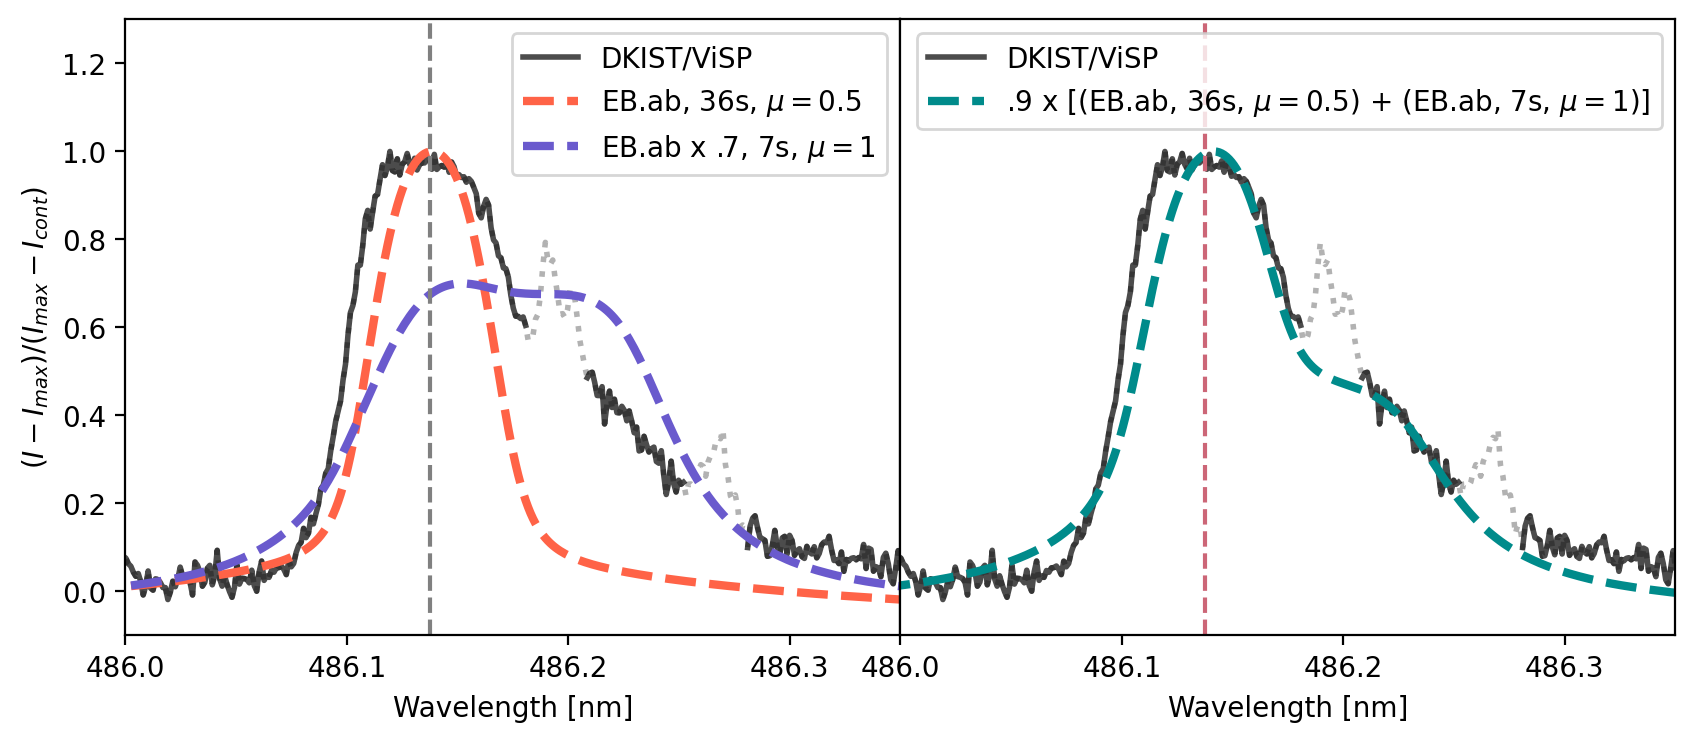

In [266]:
# for the last pixel - try to explain by combining two models, one redshifted?
i=-1
fig,[ax,ax2]=plt.subplots(1,2,figsize=(10,4),dpi=200)
ax.plot(dkist_wl,normalize_range(vispcurve2,contmin=hbeta_low),alpha=0.7,linewidth=2,c='black',label='DKIST/ViSP')
ax.plot(dkist_wl,normalize_range(vispcurve,contmin=hbeta_low),alpha=0.3,linewidth=2,linestyle='dotted',c='black')

ax.plot(dkist_wl,normalize_range(modelscomp[2],contmin=hbeta_low),linewidth=3,color='tomato',linestyle=modstyles[j],label='EB.ab, 36s, $\mu=0.5$')
ax.plot(dkist_wl,normalize_range(modelscomp[3],contmin=hbeta_low)*0.7,linewidth=3,color='slateblue',linestyle=modstyles[j],label='EB.ab x .7, 7s, $\mu=1$')


ax.set_xlim([486.0,486.35])
ax.set_ylim([-0.1,1.3])

added = normalize_range(modelscomp[2],contmin=lowvisp)+normalize_range(modelscomp[3],contmin=hbeta_low)*0.7
ax2.plot(dkist_wl,normalize_range(vispcurve2,contmin=hbeta_low),alpha=0.7,linewidth=2,c='black',label='DKIST/ViSP')
ax2.plot(dkist_wl,normalize_range(vispcurve,contmin=hbeta_low),alpha=0.3,linewidth=2,linestyle='dotted',c='black')

ax2.plot(dkist_wl,normalize_range(added,contmin=hbeta_low),linewidth=3,color='darkcyan',linestyle=modstyles[j],label='.9 x [(EB.ab, 36s, $\mu=0.5$) + (EB.ab, 7s, $\mu=1$)]')
ax2.set_xlim([486.0,486.35])

ax2.set_ylim([-0.1,1.3])
ax2.set_yticks([])
fig.subplots_adjust(wspace=0)

ax.set_ylabel(r'$(I-I_{max})/(I_{max}-I_{cont})$')
ax.set_xlabel('Wavelength [nm]')
ax2.set_xlabel('Wavelength [nm]')

ax.axvline(486.1375,c='grey',linestyle='dashed')

ax2.axvline(486.1375,c='#CC6677',linestyle='dashed')
ax.set_xticks([486.0,486.1,486.2,486.3])
ax2.set_xticks([486.0,486.1,486.2,486.3])

ax.legend()
ax2.legend()


In [ ]:
# with smoothing spline
# for the last pixel - try to explain by combining two models, one redshifted?
fig,[ax,ax2]=plt.subplots(1,2,figsize=(10,4),dpi=200)
ax.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low),alpha=0.7,linewidth=2,c=colors[i],label='DKIST/ViSP')

ax.plot(dkist_wl,normalize_range(modelscomp[2],contmin=hbeta_low),linewidth=3,color='tomato',linestyle=modstyles[j],label='EB.ab, 36s, $\mu=0.5$')
ax.plot(dkist_wl,normalize_range(modelscomp[3],contmin=hbeta_low)*0.7,linewidth=3,color='slateblue',linestyle=modstyles[j],label='EB.ab x .7, 7s, $\mu=1$')

i=-1
ax.set_xlim([486.0,486.35])
ax.set_ylim([-0.1,1.3])

added = normalize_range(modelscomp[2],contmin=lowvisp)+normalize_range(modelscomp[3],contmin=hbeta_low)*0.7
ax2.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low),alpha=0.7,linewidth=2,c=colors[i],label='DKIST/ViSP')
ax2.plot(dkist_wl,normalize_range(added,contmin=hbeta_low),linewidth=3,color='darkcyan',linestyle=modstyles[j],label='.9 x [(EB.ab, 36s, $\mu=0.5$) + (EB.ab, 7s, $\mu=1$)]')
ax2.set_xlim([486.0,486.35])

ax2.set_ylim([-0.1,1.3])
ax2.set_yticks([])
fig.subplots_adjust(wspace=0)

ax.set_ylabel(r'$(I-I_{max})/(I_{max}-I_{cont})$')
ax.set_xlabel('Wavelength [nm]')
ax2.set_xlabel('Wavelength [nm]')

ax.axvline(386.1375,c='grey',linestyle='dashed')

ax2.axvline(386.1375,c='#CC6677',linestyle='dashed')
ax.set_xticks([486.0,486.1,486.2,486.3])
ax2.set_xticks([486.0,486.1,486.2,486.3])

ax.legend()
ax2.legend()

(485.8, 486.35)

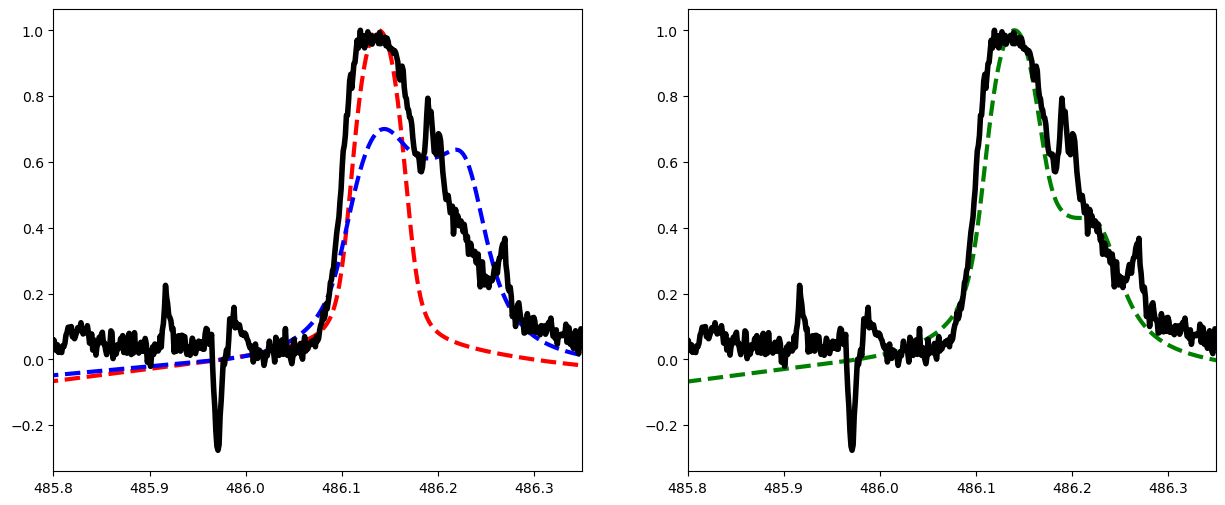

In [145]:
k = 4 #choice of extra model
# for the last pixel - try to explain by combining two models, one redshifted?
fig,[ax,ax2]=plt.subplots(1,2,figsize=(15,6))
ax.plot(dkist_wl,normalize_range(modelscomp[2],contmin=hbeta_low),linewidth=3,color='red',linestyle=modstyles[j])
ax.plot(dkist_wl,normalize_range(modelscomp[k],contmin=hbeta_low)*0.7,linewidth=3,color='blue',linestyle=modstyles[j])

i=-1
ax.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low),alpha=1,linewidth=4,c=colors[i])
ax.set_xlim([485.8,486.35])

added = normalize_range(modelscomp[2],contmin=lowvisp)+normalize_range(modelscomp[k],contmin=hbeta_low)*0.7

ax2.plot(dkist_wl,normalize_range(added,contmin=hbeta_low),linewidth=3,color='green',linestyle=modstyles[j])
ax2.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=hbeta_low),alpha=1,linewidth=4,c=colors[i])
ax2.set_xlim([485.8,486.35])

In [67]:
#load Adam's RADYN runs
baseAdam = '/Users/coletamburri/Desktop/Adam_RADYN_Runs_Jan_2026/'
filenameAdam='Hb_spec_5F12.dat'
filenameAdam_proton='Hb_spec.dat'
filenameAdam_eb5F11='Hb_spec_5F11ebeam.dat'

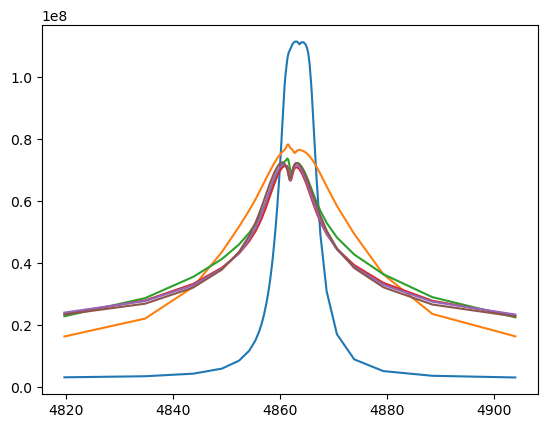

In [68]:
df = np.loadtxt(baseAdam+filenameAdam)
np.shape(df)
lam = df[:,0]
t0 = df[:,1]
t4 = df[:,2]
t6 = df[:,3]
t8 = df[:,4]
t10 = df[:,5]
t12 = df[:,6]
t14 = df[:,7]
plt.plot(lam,t4-t0)
plt.plot(lam,t6-t0)
plt.plot(lam,t8-t0)
plt.plot(lam,t10-t0)
plt.plot(lam,t12-t0)
plt.plot(lam,t14-t0)

In [77]:
from pylab import *
cmap2 = cm.get_cmap('turbo', 10) 

/var/folders/_1/p_v_pt7912z2pqq5nrvwvhlc0000gn/T/ipykernel_58761/1868804658.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('turbo', 10)


Text(0.5, 1.0, '5F11 NTP')

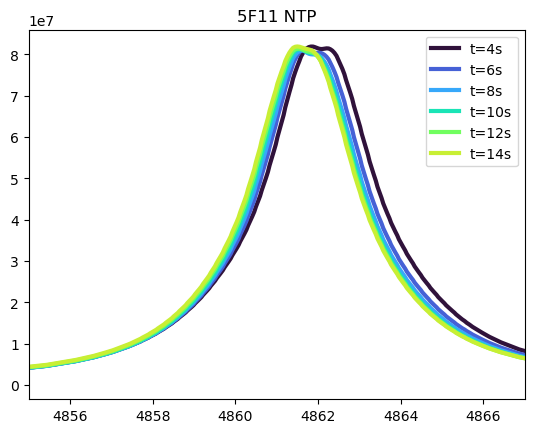

In [78]:
dfp = np.loadtxt(baseAdam+filenameAdam_proton)
np.shape(dfp)
lamp = dfp[:,0]
t0p = dfp[:,1]
t1p = dfp[:,2]
t2p = dfp[:,3]
t4p = dfp[:,4]
t6p = dfp[:,5]
t8p = dfp[:,6]
t10p = dfp[:,7]
t12p = dfp[:,8]
t14p = dfp[:,9]
plt.plot(lamp,t4p-t0p,color=cmap2(0),linewidth=3,label='t=4s')
plt.plot(lamp,t6p-t0p,color=cmap2(1),linewidth=3,label='t=6s')
plt.plot(lamp,t8p-t0p,color=cmap2(2),linewidth=3,label='t=8s')
plt.plot(lamp,t10p-t0p,color=cmap2(3),linewidth=3,label='t=10s')
plt.plot(lamp,t12p-t0p,color=cmap2(4),linewidth=3,label='t=12s')
plt.plot(lamp,t14p-t0p,color=cmap2(5),linewidth=3,label='t=14s')
plt.legend()
plt.xlim([4855,4867])
plt.title('5F11 NTP')

Text(0.5, 1.0, '5F11 NTE')

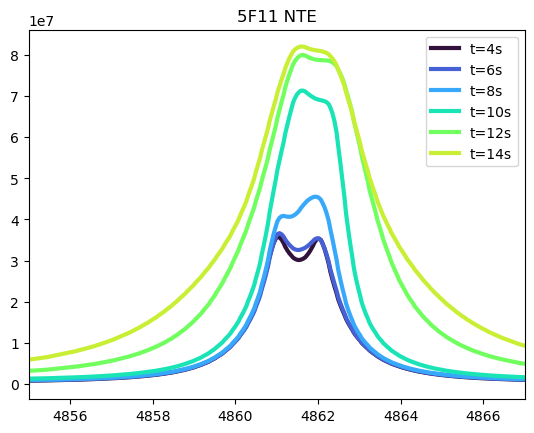

In [79]:
dfe5F11 = np.loadtxt(baseAdam+filenameAdam_eb5F11)
np.shape(dfe5F11)
lame5F11 = dfe5F11[:,0]
t0e5F11 = dfe5F11[:,1]
t1e5F11 = dfe5F11[:,2]
t2e5F11 = dfe5F11[:,3]
t4e5F11 = dfe5F11[:,4]
t6e5F11 = dfe5F11[:,5]
t8e5F11 = dfe5F11[:,6]
t10e5F11 = dfe5F11[:,7]
t12e5F11 = dfe5F11[:,8]
t14e5F11 = dfe5F11[:,9]
plt.plot(lame5F11,t4e5F11-t0e5F11,color=cmap2(0),linewidth=3,label='t=4s')
plt.plot(lame5F11,t6e5F11-t0e5F11,color=cmap2(1),linewidth=3,label='t=6s')
plt.plot(lame5F11,t8e5F11-t0e5F11,color=cmap2(2),linewidth=3,label='t=8s')
plt.plot(lame5F11,t10e5F11-t0e5F11,color=cmap2(3),linewidth=3,label='t=10s')
plt.plot(lame5F11,t12e5F11-t0e5F11,color=cmap2(4),linewidth=3,label='t=12s')
plt.plot(lame5F11,t14e5F11-t0e5F11,color=cmap2(5),linewidth=3,label='t=14s')
plt.xlim([4855,4867])
plt.legend()
plt.title('5F11 NTE')

(4855.0, 4867.0)

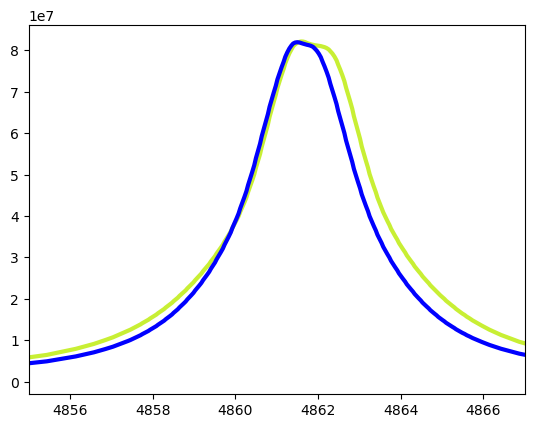

In [80]:
plt.plot(lame5F11,t14e5F11-t0e5F11,color=cmap2(5),linewidth=3,label='t=14s')
plt.plot(lamp,t14p-t0p,color='blue',linewidth=3)
plt.xlim([4855,4867])

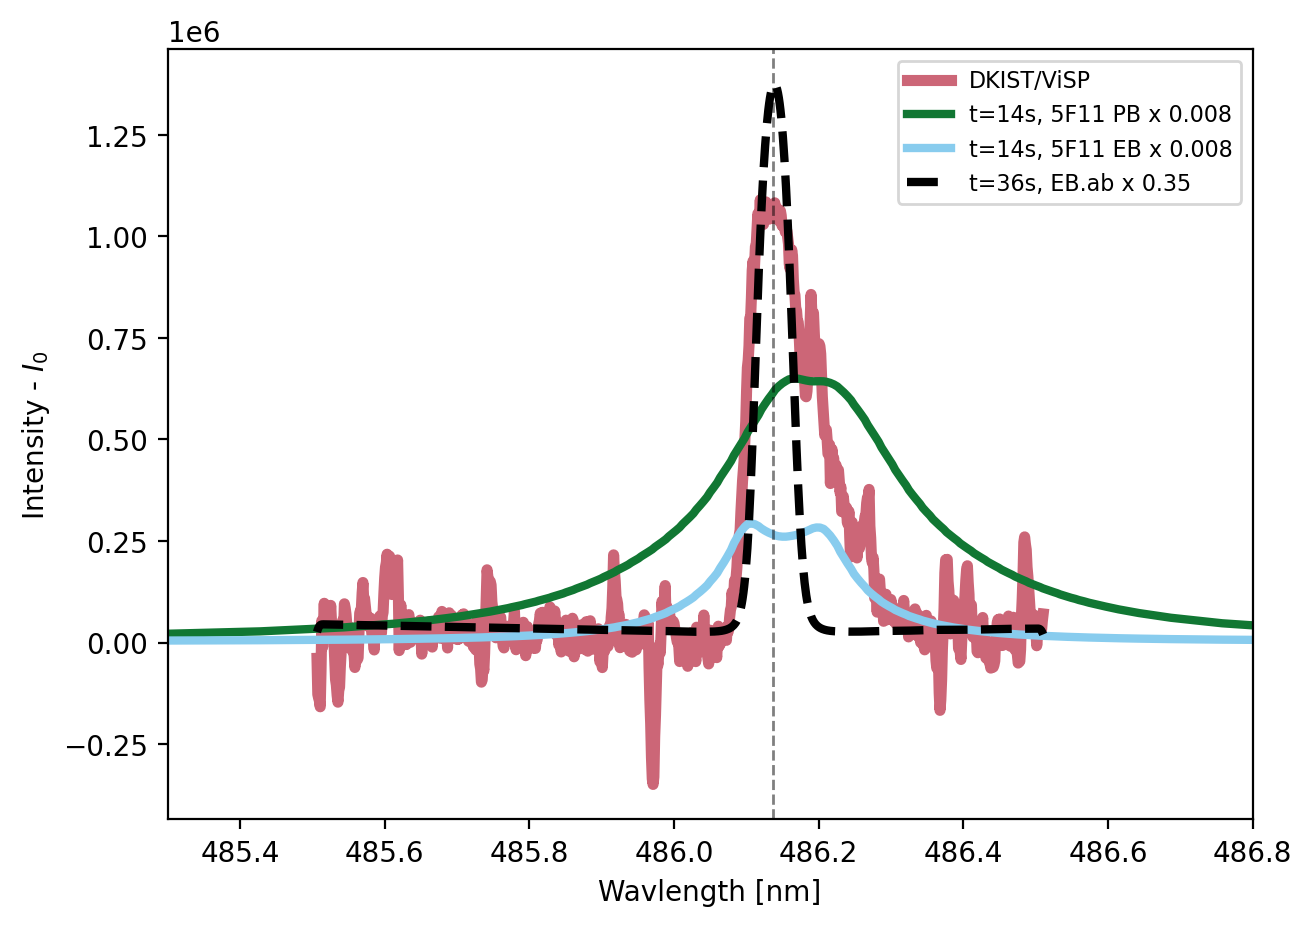

In [88]:
fig,ax=plt.subplots(dpi=200,figsize=(7,5))
colors=tol_colors.tol_cset('muted')
i=4

ax.plot(dkist_wl,dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])]-0.25e6,alpha=1,linewidth=4,c=colors[0],label='DKIST/ViSP')

ax.plot(lamp/10,(t6p-t0p)*.008,label='t=14s, 5F11 PB x 0.008',c=colors[3],linewidth=3)

ax.plot(lame5F11/10,(t6e5F11-t0e5F11)*.008,label='t=14s, 5F11 EB x 0.008',c=colors[4],linewidth=3)

ax.plot(dkist_wl,modelscomp[0]*0.35,linewidth=3,color=colors[10],linestyle=modstyles[j],label='t=36s, EB.ab x 0.35')

ax.set_xlim([485.3,486.8])
#ax[i].set_ylim([-0.1,1.1])
ax.axvline(486.1375,c='black',linestyle='dashed',linewidth=1,alpha=0.5)
ax.set_xlabel('Wavlength [nm]')
ax.set_ylabel(r'Intensity - $I_0$')
ax.legend(fontsize=8)

In [156]:
# select - part of adam's run that is the wavelength range from dkist
lowwl = dkist_wl[0]
highwl = dkist_wl[-1]

lowval, lowind = find_nearest(lamp/10,lowwl)
highval,highind = find_nearest(lamp/10,highwl)


In [157]:
# same for eb
lowvale, lowinde = find_nearest(lame5F11/10,lowwl)
highvale,highinde = find_nearest(lame5F11/10,highwl)

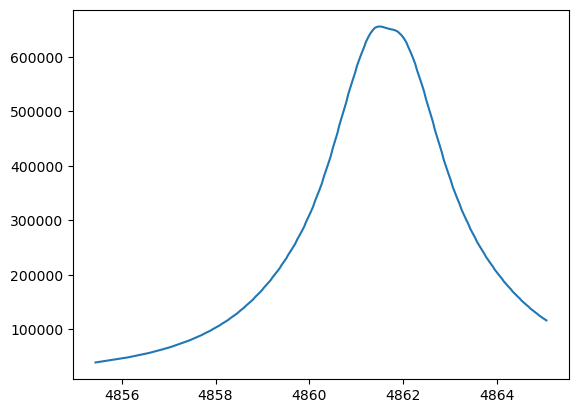

In [158]:
sampwl = lamp[lowind:highind]/10
pb5f11 = (t14p[lowind:highind]-t0p[lowind:highind])*.01
plt.plot(lamp[lowind:highind],(t14p[lowind:highind]-t0p[lowind:highind])*.008)



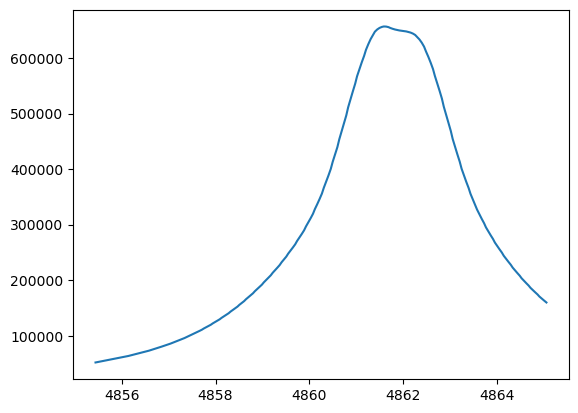

In [159]:
sampwle = lame5F11[lowinde:highinde]/10
eb5f11 = (t14e5F11[lowinde:highinde]-t0e5F11[lowinde:highinde])*.01
plt.plot(lame5F11[lowinde:highinde],(t14e5F11[lowinde:highinde]-t0e5F11[lowinde:highinde])*.008)

In [160]:
f_interp = interp1d(sampwl,pb5f11,bounds_error=False, fill_value="extrapolate")
pb5f11_interp = f_interp(dkist_wl)

In [161]:
f_interpe = interp1d(sampwle,eb5f11,bounds_error=False, fill_value="extrapolate")
eb5f11_interp = f_interpe(dkist_wl)

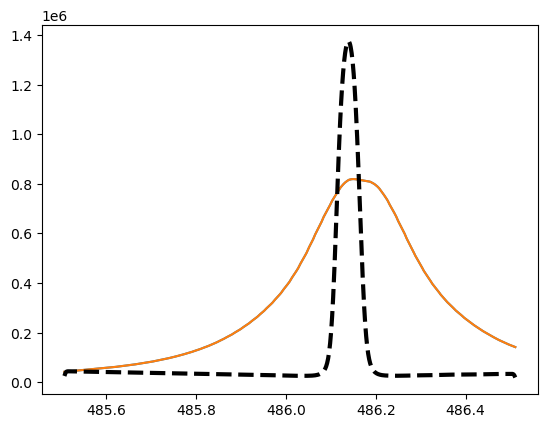

In [162]:
plt.plot(dkist_wl,pb5f11_interp)
plt.plot(dkist_wl,pb5f11_interp)
plt.plot(dkist_wl,modelscomp[0]*0.35,linewidth=3,color=colors[10],linestyle=modstyles[j],label='t=36s, EB.ab x 0.35')


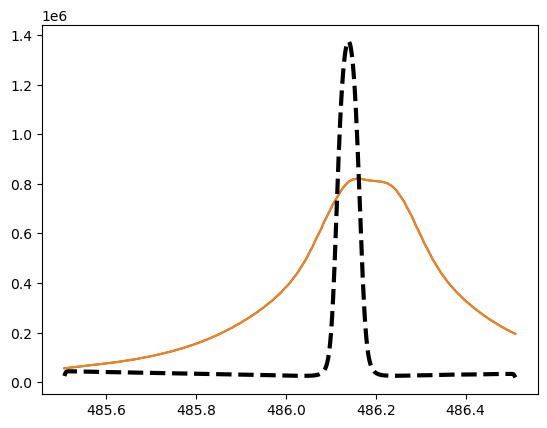

In [163]:
plt.plot(dkist_wl,eb5f11_interp)
plt.plot(dkist_wl,eb5f11_interp)
plt.plot(dkist_wl,modelscomp[0]*0.35,linewidth=3,color=colors[10],linestyle=modstyles[j],label='t=36s, EB.ab x 0.35')


In [164]:
EB_PB = pb5f11_interp+modelscomp[0]*0.35

In [165]:
EB_EB5F11 = eb5f11_interp+modelscomp[0]*0.35

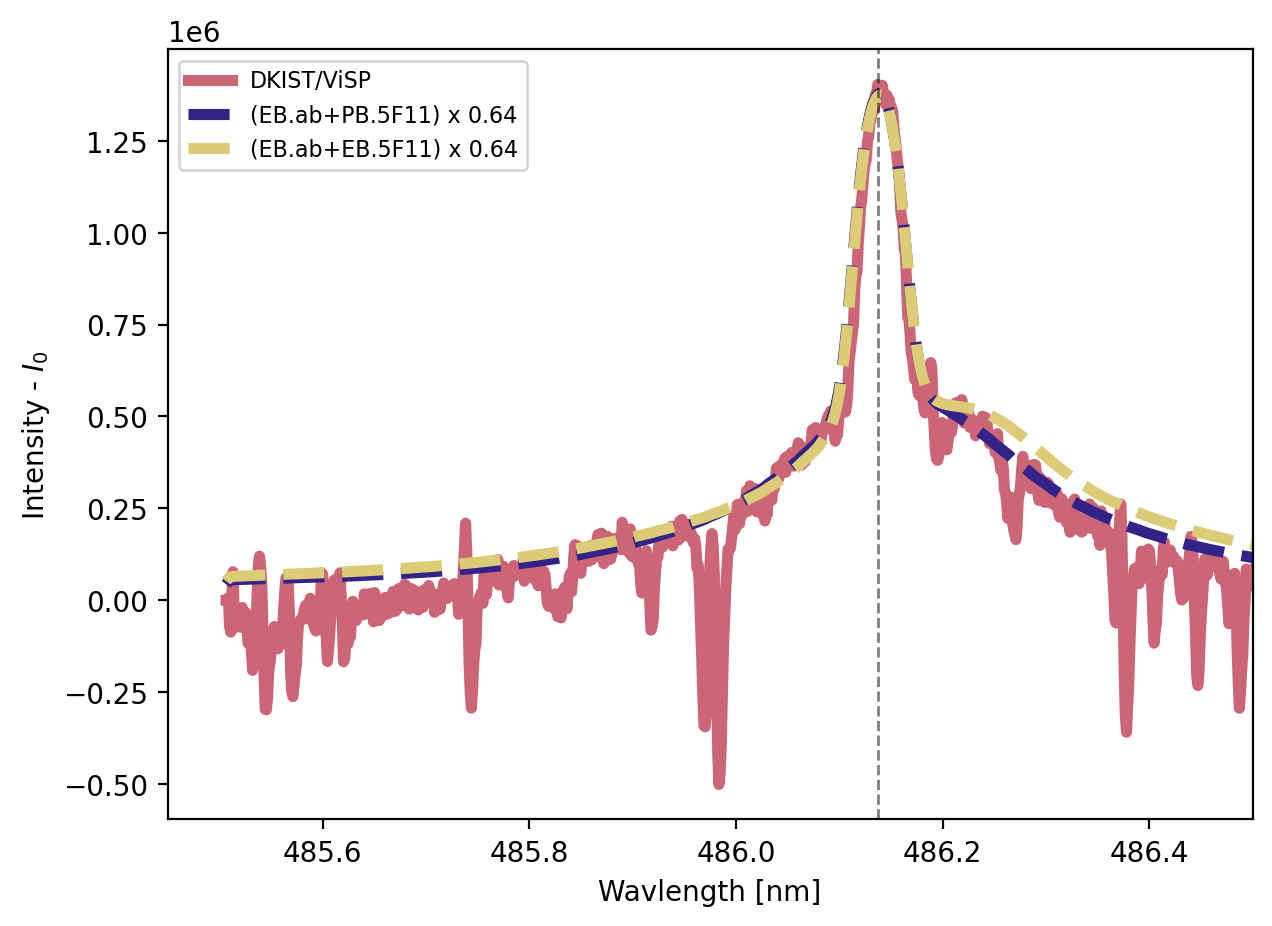

In [171]:
fig,ax=plt.subplots(dpi=200,figsize=(7,5))
colors=tol_colors.tol_cset('muted')
i=0
#for i in range(1):
    # #ax[i].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low),alpha=1,linewidth=4,c=colors[i])
    # ax.flatten()[i].plot(dkist_wl,dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],alpha=1,linewidth=4,c=colors[i])
    # #ax[i].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
    # ax.flatten()[i].plot(lam/10,(t14-t0)*.02,label='t=14s, 5F12 EB x 0.2')
    # ax.flatten()[i].plot(lamp/10,(t14p-t0p)*.02,label='t=14s, 5F11 PB x 0.2')
    # ax.flatten()[i].plot(lamp/10,(t14p-t0p)*.01,label='t=14s, 5F11 PB x 0.1')

    # ax.flatten()[i].set_xlim([485.3,486.8])
    # #ax[i].set_ylim([-0.1,1.1])
    # ax.flatten()[i].axvline(486.1375,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

    #ax[i].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low),alpha=1,linewidth=4,c=colors[i])
ax.plot(dkist_wl,dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],alpha=1,linewidth=4,c=colors[0],label='DKIST/ViSP')
#ax[i].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
ax.plot(dkist_wl,EB_PB*0.63,linewidth=4,c=colors[1],linestyle = 'dashed',label='(EB.ab+PB.5F11) x 0.64')
ax.plot(dkist_wl,EB_EB5F11*0.63,linewidth=4,c=colors[2],linestyle = 'dashed',label='(EB.ab+EB.5F11) x 0.64')

ax.set_xlim([485.45,486.5])
#ax[i].set_ylim([-0.1,1.1])
ax.axvline(486.1375,c='black',linestyle='dashed',linewidth=1,alpha=0.5)
ax.set_xlabel('Wavlength [nm]')
ax.set_ylabel(r'Intensity - $I_0$')
ax.legend(fontsize=8)

In [95]:
# different - with convolution
f_interp_conv= np.add(pb5f11_interp,modelscomp[0]*0.35)

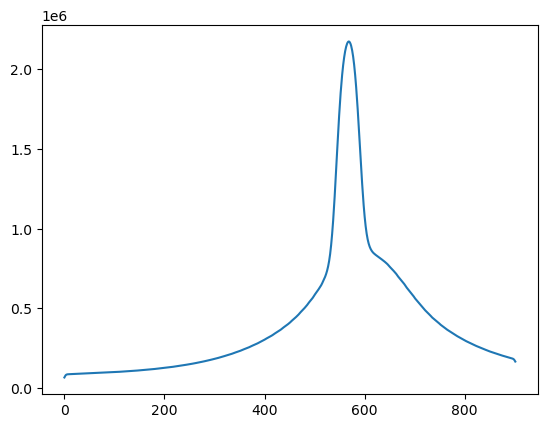

In [94]:
plt.plot(f_interp_conv)

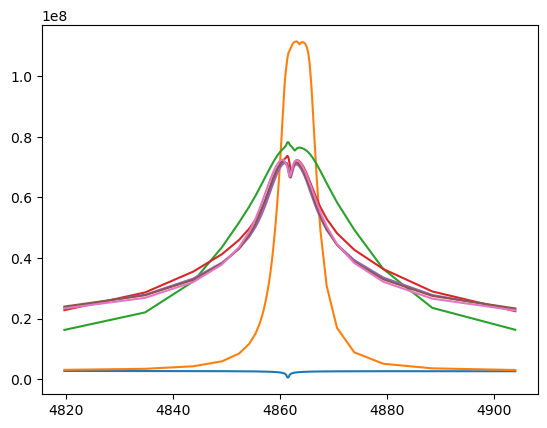

In [77]:
lam = df[:,0]
t0 = df[:,1]
t4 = df[:,2]
t6 = df[:,3]
t8 = df[:,4]
t10 = df[:,5]
t12 = df[:,6]
t14 = df[:,7]
plt.plot(lam,t0)
plt.plot(lam,t4-t0)
plt.plot(lam,t6-t0)
plt.plot(lam,t8-t0)
plt.plot(lam,t10-t0)
plt.plot(lam,t12-t0)
plt.plot(lam,t14-t0)

In [74]:
len(dkist_wl)

902

In [75]:
dkist_wl[0]

np.float64(485.50667452745057)

In [76]:
dkist_wl[-1]

np.float64(486.51059448309974)

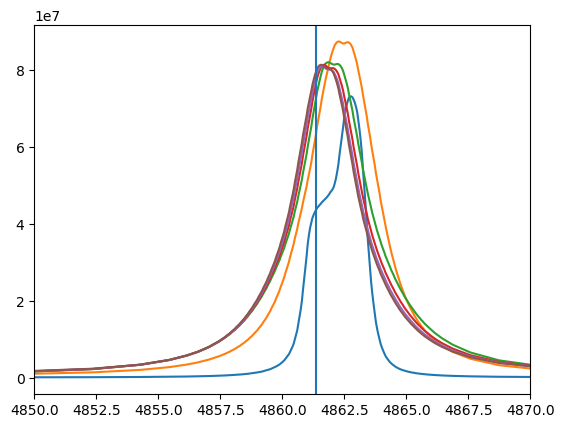

In [127]:
plt.plot(lamp,t4p-t0p)
plt.plot(lamp,t6p-t0p)
plt.plot(lamp,t8p-t0p)
plt.plot(lamp,t10p-t0p)
plt.plot(lamp,t12p-t0p)
plt.plot(lamp,t14p-t0p)
plt.xlim([4850,4870])
plt.axvline(4861.35)

0.0125